In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Preprocess Data

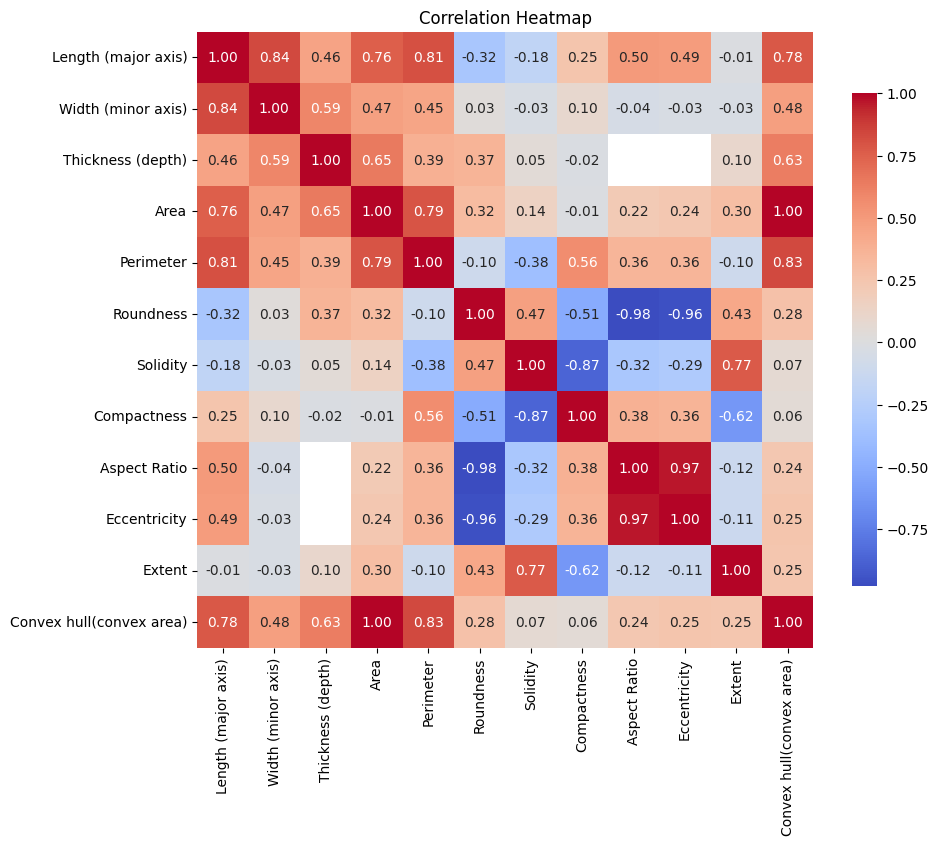

In [3]:
df = pd.read_csv("inputs/Almond.csv")

X = df.drop(columns=["Unnamed: 0", "Type"])
y = df["Type"]

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 2. Build Neural Network Model

In [4]:
def create_model(neurons=32, optimizer='adam'):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(neurons // 2, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))  # 3 classes
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 3. Hyperparameter Optimization (Grid Search)

C:\Users\Josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neurons: 32, Optimizer: adam, Epochs: 50 - Test Accuracy: 0.7344028353691101
Neurons: 32, Optimizer: adam, Epochs: 100 - Test Accuracy: 0.7504456043243408
Neurons: 32, Optimizer: sgd, Epochs: 50 - Test Accuracy: 0.6827094554901123
Neurons: 32, Optimizer: sgd, Epochs: 100 - Test Accuracy: 0.7040998339653015
Neurons: 32, Optimizer: rmsprop, Epochs: 50 - Test Accuracy: 0.7183600664138794
Neurons: 32, Optimizer: rmsprop, Epochs: 100 - Test Accuracy: 0.7468805909156799
Neurons: 64, Optimizer: adam, Epochs: 50 - Test Accuracy: 0.7433155179023743
Neurons: 64, Optimizer: adam, Epochs: 100 - Test Accuracy: 0.7575757503509521
Neurons: 64, Optimizer: sgd, Epochs: 50 - Test Accuracy: 0.6809269189834595
Neurons: 64, Optimizer: sgd, Epochs: 100 - Test Accuracy: 0.7076649069786072
Neurons: 64, Optimizer: rmsprop, Epochs: 50 - Test Accuracy: 0.7397504448890686
Neurons: 64, Optimizer: rmsprop, Epochs: 100 - Test Accuracy: 0.759358286857605
Neurons: 128, Optimizer: adam, Epochs: 50 - Test Accuracy: 0.75

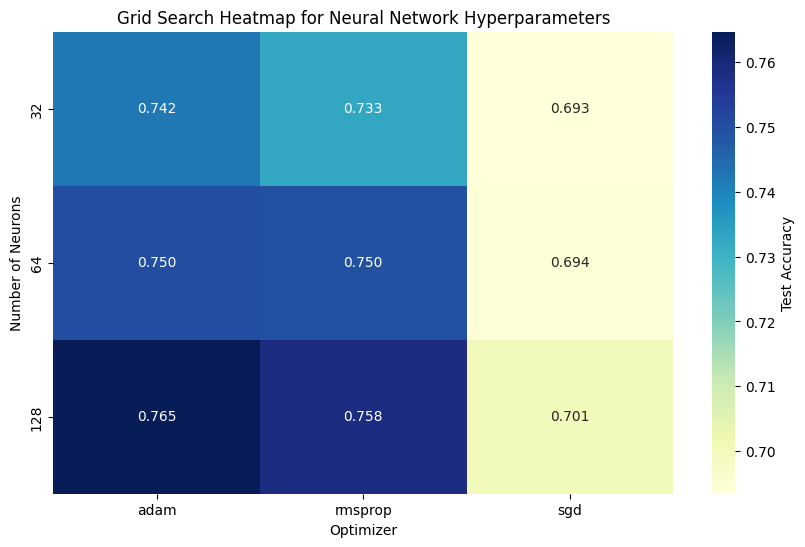

In [5]:
# Grid Search Parameters
neurons_list = [32, 64, 128]
optimizers = ['adam', 'sgd', 'rmsprop']
epochs_list = [50, 100]

best_acc = 0
best_params = None
results = []

for neurons in neurons_list:
    for optimizer in optimizers:
        for epochs in epochs_list:
            model = create_model(neurons=neurons, optimizer=optimizer)
            model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

            # Evaluate the model
            test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
            print(f"Neurons: {neurons}, Optimizer: {optimizer}, Epochs: {epochs} - Test Accuracy: {test_acc}")

            results.append({
                'neurons': neurons,
                'optimizer': optimizer,
                'epochs': epochs,
                'accuracy': test_acc
            })
            
            # Track the best performing model
            if test_acc > best_acc:
                best_acc = test_acc
                best_params = (neurons, optimizer, epochs)


print(f"Best configuration - Neurons: {best_params[0]}, Optimizer: {best_params[1]}, Epochs: {best_params[2]} with Accuracy: {best_acc}")


results_df = pd.DataFrame(results)
heatmap_data = results_df.pivot_table(index='neurons', columns='optimizer', values='accuracy')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={"label": "Test Accuracy"})
plt.title("Grid Search Heatmap for Neural Network Hyperparameters")
plt.xlabel("Optimizer")
plt.ylabel("Number of Neurons")
plt.show()

# 4. Comparative Study of Optimizers

C:\Users\Josep\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7454 - loss: 0.5908 
Optimizer: adam, Test Accuracy: 0.7486631274223328
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6928 - loss: 0.6792
Optimizer: sgd, Test Accuracy: 0.675579309463501
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7363 - loss: 0.6108
Optimizer: rmsprop, Test Accuracy: 0.7361853718757629


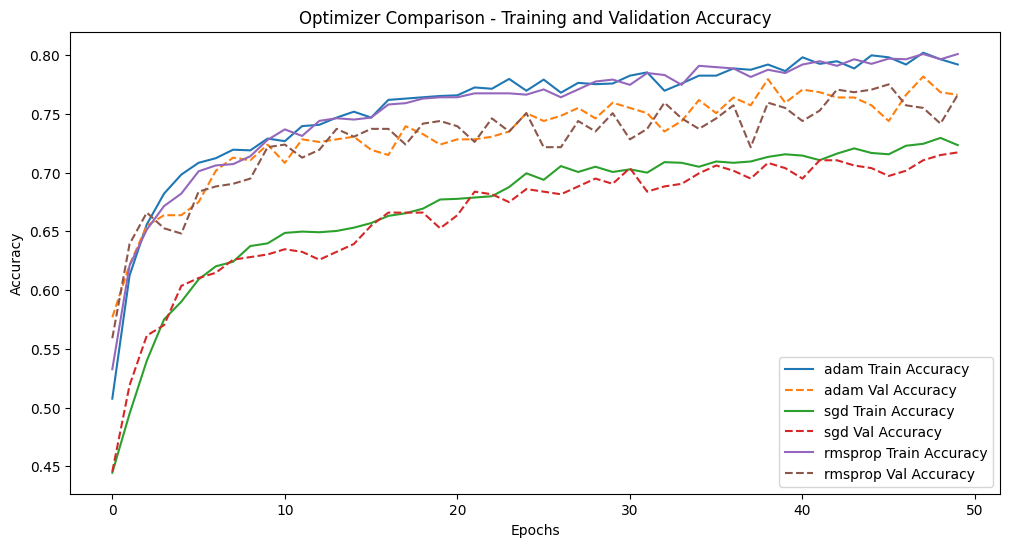

In [6]:
optimizers = ['adam', 'sgd', 'rmsprop']
history_dict = {}

for opt in optimizers:
    model = create_model(neurons=64, optimizer=opt)
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
    history_dict[opt] = history.history
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Optimizer: {opt}, Test Accuracy: {test_acc}")

plt.figure(figsize=(12, 6))

for opt in optimizers:
    plt.plot(history_dict[opt]['accuracy'], label=f'{opt} Train Accuracy')
    plt.plot(history_dict[opt]['val_accuracy'], '--', label=f'{opt} Val Accuracy')


plt.title('Optimizer Comparison - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 5. Hybrid Learning Algorithm:

In [7]:
import tensorflow as tf

# Define the custom RProp optimizer class
class RPropOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, eta_plus=1.2, eta_minus=0.5, delta_min=1e-6, delta_max=50.0, name="RProp", **kwargs):
        super(RPropOptimizer, self).__init__(name=name, learning_rate=learning_rate, **kwargs)
        self.learning_rate = learning_rate
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max

    def apply_gradients(self, grads_and_vars, name=None):
        for grad, var in grads_and_vars:
            if grad is None:
                continue
            grad_sign = tf.sign(grad)
            var.assign_sub(grad_sign * self.learning_rate)

    def get_config(self):
        return {
            'learning_rate': self.learning_rate,
            'eta_plus': self.eta_plus,
            'eta_minus': self.eta_minus,
            'delta_min': self.delta_min,
            'delta_max': self.delta_max,
        }

# Hybrid optimizer combining RProp and Adam
class HybridOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, rprop_optimizer, adam_optimizer, name="HybridOptimizer", **kwargs):
        super(HybridOptimizer, self).__init__(name=name, learning_rate=0.001, **kwargs)
        self.rprop_optimizer = rprop_optimizer
        self.adam_optimizer = adam_optimizer

    def apply_gradients(self, grads_and_vars, name=None):
        # Apply gradients with RProp
        self.rprop_optimizer.apply_gradients(grads_and_vars)
        # Apply gradients with Adam
        adam_grands_and_vars = [(grad, var) for grad, var in grads_and_vars if grad is not None]
        if adam_grands_and_vars:
            self.adam_optimizer.apply_gradients(grads_and_vars)

    def get_config(self):
        return {
            'rprop_optimizer': self.rprop_optimizer.get_config(),
            'adam_optimizer': self.adam_optimizer.get_config(),
        }

rprop_optimizer = RPropOptimizer(learning_rate=0.001)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

hybrid_optimizer = HybridOptimizer(rprop_optimizer, adam_optimizer)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes (Mamra, Sanora, Regular)
])

model.compile(optimizer=hybrid_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy with Hybrid RProp and Adam: {test_acc}")

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3934 - loss: 1.0587 - val_accuracy: 0.5546 - val_loss: 0.8874
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5661 - loss: 0.8629 - val_accuracy: 0.6214 - val_loss: 0.8130
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6310 - loss: 0.8097 - val_accuracy: 0.6347 - val_loss: 0.7718
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6613 - loss: 0.7541 - val_accuracy: 0.6682 - val_loss: 0.7330
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6708 - loss: 0.7559 - val_accuracy: 0.6815 - val_loss: 0.7100
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7116 - loss: 0.7040 - val_accuracy: 0.6726 - val_loss: 0.7067
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7083 - loss: 0.7007 - val_accuracy: 0.6904 - val_loss: 0.6849
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7062 - loss: 0.7113 - val_accuracy: 0.6860 - val_loss:

# 6. Visualisation 

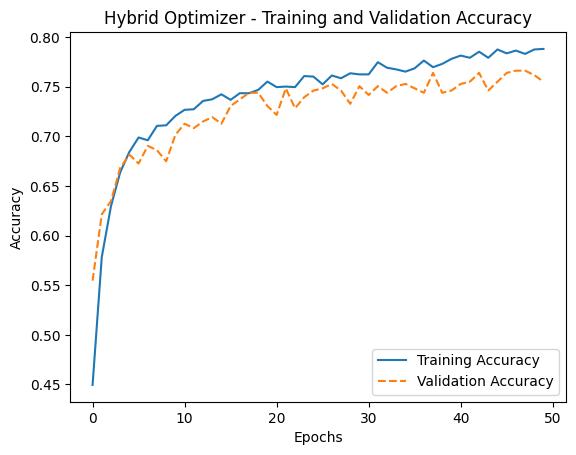

In [8]:
# Plot training vs validation accuracy for hybrid optimizer
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], '--', label='Validation Accuracy')
plt.title('Hybrid Optimizer - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()